In [ ]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
# listen to noisy music in notebook
from IPython.display import Audio

**Students**:
- Nikita Kiselov
- Marwan Mashra 

## Read music file

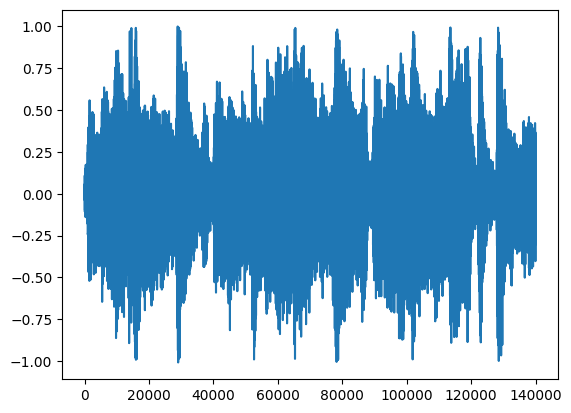

In [ ]:
file_name = "audio/music.wav"
rate, music_sig = wav.read(file_name)
music_sig = (music_sig - music_sig.mean()) / music_sig.max()
plt.plot(music_sig)
plt.show()

In [ ]:
# play clean music
Audio(music_sig, rate=rate)

## Add noise to the music

Here we add noise to the music with various SNR levels. We know that for Gaussian noise, the SNR can be computed as following:
$$
\text{SNR} = 10*\log_{10}(\frac{||x||_{2}^{2}}{||n||_{2}^{2}})
$$
Such that $x$ is the signal, and $n$ is Gaussian noise. If we want to add a certain amout of noise controlling the SNR, we need to introduce a new parameter $\alpha$ to control the amout of nosie added :
$$
\text{SNR} = 10*\log_{10}(\frac{||x||_{2}^{2}}{\alpha^2||n||_{2}^{2}})
$$
And by solving the equation for $\alpha$, we find that :
$$
\alpha = \sqrt{\frac{||x||_{2}^{2}}{10^{\frac{\text{SNR}}{10}}||n||_{2}^{2}}}
$$
Finally, our noisy signal for a given level of SNR will be:
$$
\text{Noisy signal} = x + \sqrt{\frac{||x||_{2}^{2}}{10^{\frac{\text{SNR}}{10}}||n||_{2}^{2}}}
$$

In [ ]:
# read noise 
file_name = "audio/noise1.wav"
rate, noise_sig = wav.read(file_name)
noise_sig = (noise_sig - noise_sig.mean()) / noise_sig.max()

noisy_musics = {}
for snr in [5, 10, 15, 20]:
    Em = (music_sig**2).sum()
    En = (noise_sig**2).sum()
    alpha = np.sqrt(Em / (En*10**(snr/10)))
    # add noise to music
    noisy_musics[snr] = music_sig + alpha*noise_sig
noisy_musics

{5: array([-0.17492152, -0.00038554,  0.05748255, ..., -0.18674294,
         0.1474499 , -0.25283484]),
 10: array([-0.09586058, -0.00225198,  0.02680143, ..., -0.12576293,
         0.08561598, -0.12271791]),
 15: array([-0.05140134, -0.00330156,  0.00954817, ..., -0.09147135,
         0.05084422, -0.04954779]),
 20: array([-0.02640008, -0.00389178, -0.00015405, ..., -0.07218778,
         0.03129062, -0.00840121])}

In [ ]:
# play denoised music
Audio(noisy_musics[10], rate=rate)

## Spectral substraction method

$y$ - the noisy music  
$n$ - the noise signal

Our goal is to estimate the clean signal $x$ from the noisy signal $y$. For this we will use the **spectral substraction method** (Hard threshholding).

$$
X(\tau, v) = Y(\tau, v) \max \left\{1 - \lambda^2\frac{|S_n(v)|^2}{|Y(\tau, v)|^2}, 0 \right\}, 
$$

where $S_n(v)$ is the Power Density estimation of noise $n$.  
$Y(\tau, v)$ is the STFT of the noisy signal $y$.
$$

To estimate the Power Density of the noise we will use the **Welch method** and STFT by scipy.signal package. Note that we used scaling='spectrum' in order to get the same scale in terms of the measurments.

In [ ]:
# take the STFT of the noisy music
noisy_music = noisy_musics[10]
f, t, y = signal.stft(noisy_music, rate, nperseg=256, scaling="spectrum")
# calculate the power density spectrum of the noise
f, Sn = signal.welch(noise_sig, rate, nperseg=256, scaling="spectrum")

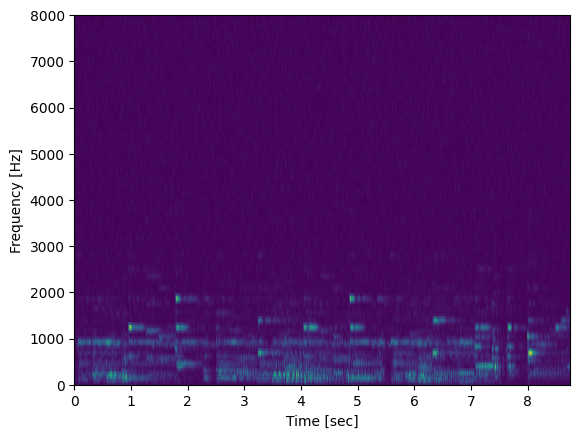

In [ ]:
# plot the spectrogram
plt.pcolormesh(t, f, np.abs(y), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

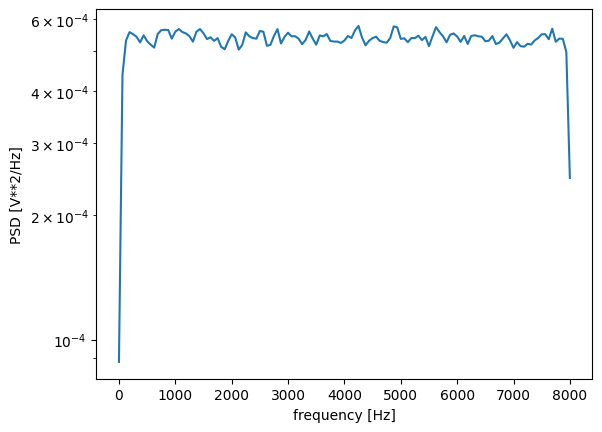

In [ ]:
# plot the power density spectrum of the noise
plt.semilogy(f, Sn)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


In [ ]:
lmbd = 10 # lambda parameter
lf = (1-(lmbd**2)*(Sn**2)/y.T**2)
# fill inf values with 0
lf[np.isinf(lf)] = 0
lf[lf<0] = 0
y_denoised = y.T*lf

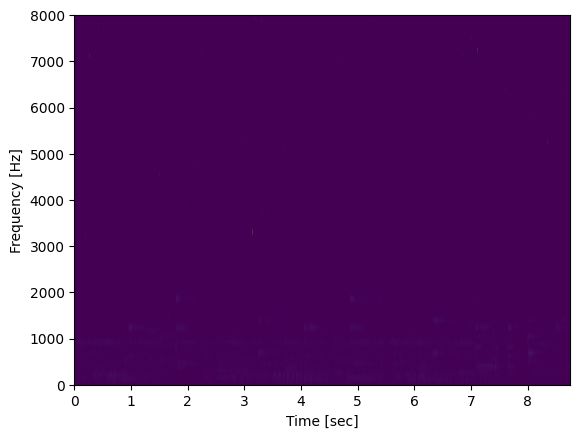

In [ ]:
plt.pcolormesh(t, f, np.abs(y_denoised.T), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# inverse stft to get the denoised music
t, denoised_music = signal.istft(y_denoised.T, rate, scaling="spectrum")
# play denoised music
Audio(denoised_music, rate=rate)

In [ ]:
Audio(noisy_music, rate=rate)

## In a cycle

In [ ]:
def spectral_substraction_denoising(noisy_music, sig, rate, lmbd, nperseg=256):
    # take the STFT of the noisy music
    f, t, y = signal.stft(noisy_music, rate, nperseg=256, scaling="spectrum")
    # calculate the power density spectrum of the noise
    f, Sn = signal.welch(sig, rate, nperseg=256, scaling="spectrum")
    # We transpose the STFT matrix to make it easier to work with
    y = y.T
    # calculate the spectral subtraction matrix 
    lf = (1-(lmbd**2)*(Sn**2)/abs(y)**2)
    # hard thresholding
    lf[lf<0] = 0
    lf[np.isinf(lf)] = 0
    # apply the spectral subtraction matrix to the STFT matrix
    y = y*lf

    # inverse stft to get the denoised music
    t, denoised_music = signal.istft(y.T, rate, scaling="spectrum")
    return denoised_music

In [ ]:
# list of lmdb values from 1 to 100
noisy_music = noisy_musics[10]
lmbd_list = np.arange(0,100,1)
snr_list = []
for lmbd in lmbd_list:
    # denoise the music
    denoised_music = spectral_substraction_denoising(noisy_music, noise_sig, rate, lmbd)
    # calcualte the SNR of the denoised music
    SNR = 10*np.log10(np.var(music_sig)/np.var((music_sig-denoised_music[:music_sig.shape[0]])))
    snr_list.append(SNR)
    print(f"Lambda: {lmbd.round(2)} | SNR denoise = ", SNR.round(2))


Lambda: 0 | SNR denoise =  10.0
Lambda: 1 | SNR denoise =  10.06
Lambda: 2 | SNR denoise =  10.23
Lambda: 3 | SNR denoise =  10.49
Lambda: 4 | SNR denoise =  10.85
Lambda: 5 | SNR denoise =  11.27
Lambda: 6 | SNR denoise =  11.75
Lambda: 7 | SNR denoise =  12.27
Lambda: 8 | SNR denoise =  12.79
Lambda: 9 | SNR denoise =  13.31
Lambda: 10 | SNR denoise =  13.79
Lambda: 11 | SNR denoise =  14.21
Lambda: 12 | SNR denoise =  14.56
Lambda: 13 | SNR denoise =  14.82
Lambda: 14 | SNR denoise =  14.98
Lambda: 15 | SNR denoise =  15.06
Lambda: 16 | SNR denoise =  15.05
Lambda: 17 | SNR denoise =  14.99
Lambda: 18 | SNR denoise =  14.87
Lambda: 19 | SNR denoise =  14.71
Lambda: 20 | SNR denoise =  14.53
Lambda: 21 | SNR denoise =  14.32
Lambda: 22 | SNR denoise =  14.11
Lambda: 23 | SNR denoise =  13.88
Lambda: 24 | SNR denoise =  13.66
Lambda: 25 | SNR denoise =  13.43
Lambda: 26 | SNR denoise =  13.21
Lambda: 27 | SNR denoise =  12.98
Lambda: 28 | SNR denoise =  12.76
Lambda: 29 | SNR denoise 

In [ ]:
noisy_SNR = 10*np.log10(np.var(music_sig)/np.var((music_sig-noisy_music)))
print("Noisy music SNR: ", noisy_SNR)

Noisy music SNR:  10.0


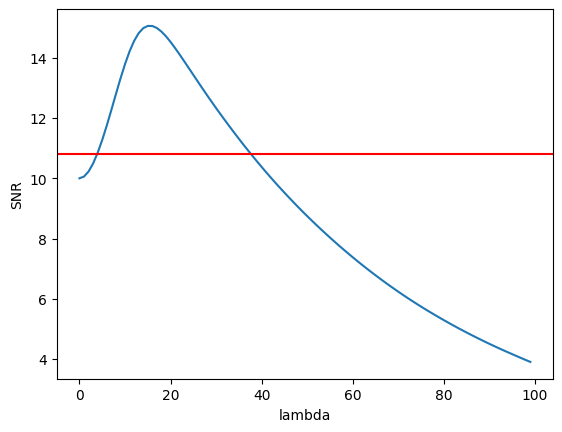

In [ ]:
# plot the SNR vs lambda
plt.plot(lmbd_list, snr_list)
# plot red line at zero SNR
plt.axhline(y=10.79, color='r', linestyle='-')
plt.xlabel('lambda')
plt.ylabel('SNR')
plt.show()

In [ ]:
best_snr = max(snr_list)
best_lambda = lmbd_list[np.array(snr_list).argmax()]
print(f'best SNR we got is {best_snr:.2f} (lambda={best_lambda})')

best SNR we got is 15.06 (lambda=15)


Let's try it and see what we get.

In [ ]:
denoised_audio = spectral_substraction_denoising(noisy_music, noise_sig, rate, best_lambda)
Audio(denoised_audio, rate=rate)

In [ ]:
denoised_audio = spectral_substraction_denoising(noisy_music, noise_sig, rate, best_lambda*1.5)
Audio(denoised_audio, rate=rate)

## Denoising for each noise type

In [ ]:
noise_files = ["noise1.wav", "noise2.wav", "noise3.wav"]
nlevel = 0.3 # noise level. It is multiplied by the noise signal 
noisy_music_dict = {}
noises_dict = {}
SNR_LIST = [5, 10, 20]
for file in noise_files:
    rate, noise_sig = wav.read("audio/"+file)
    noise_sig = (noise_sig - noise_sig.mean()) / noise_sig.max()
    noises_dict[file] = noise_sig
    noisy_music_dict[file] = {}
    for snr in SNR_LIST:
        # add noise to music
        Em = (music_sig**2).sum()
        En = (noise_sig**2).sum()
        alpha = np.sqrt(Em / (En*10**(snr/10)))
        # add noise to music
        noisy_music_dict[file][snr] = music_sig + alpha*noise_sig
noisy_music_dict

{'noise1.wav': {5: array([-0.17492152, -0.00038554,  0.05748255, ..., -0.18674294,
          0.1474499 , -0.25283484]),
  10: array([-0.09586058, -0.00225198,  0.02680143, ..., -0.12576293,
          0.08561598, -0.12271791]),
  20: array([-0.02640008, -0.00389178, -0.00015405, ..., -0.07218778,
          0.03129062, -0.00840121])},
 'noise2.wav': {5: array([-0.09108314, -0.1353838 , -0.22323924, ..., -0.13117276,
         -0.07430785, -0.13897806]),
  10: array([-0.04871479, -0.07816708, -0.13106003, ..., -0.09451352,
         -0.03908756, -0.05869155]),
  20: array([-0.01149127, -0.02789824, -0.05007423, ..., -0.06230585,
         -0.00814411,  0.01184571])},
 'noise3.wav': {5: array([-0.19090498, -0.09427631, -0.11220506, ..., -0.20552372,
          0.04925172, -0.2962457 ]),
  10: array([-0.10484874, -0.05505064, -0.06862092, ..., -0.13632414,
          0.03039509, -0.14712964]),
  20: array([-0.02924238, -0.02058818, -0.03032925, ..., -0.07552753,
          0.01382824, -0.01612087

In [ ]:
def get_snr_curve(noisy_music, noise_sig, original_music):
    # list of lmdb values from 1 to 100
    lmbd_list = np.arange(0,100,1)
    snr_list = []
    for lmbd in lmbd_list:
        # denoise the music
        denoised_music = spectral_substraction_denoising(noisy_music, noise_sig, rate, lmbd)
        # calcualte the SNR of the denoised music
        SNR = 10*np.log10(np.var(music_sig)/np.var((music_sig-denoised_music[:music_sig.shape[0]])))
        snr_list.append(SNR)
        
    return snr_list

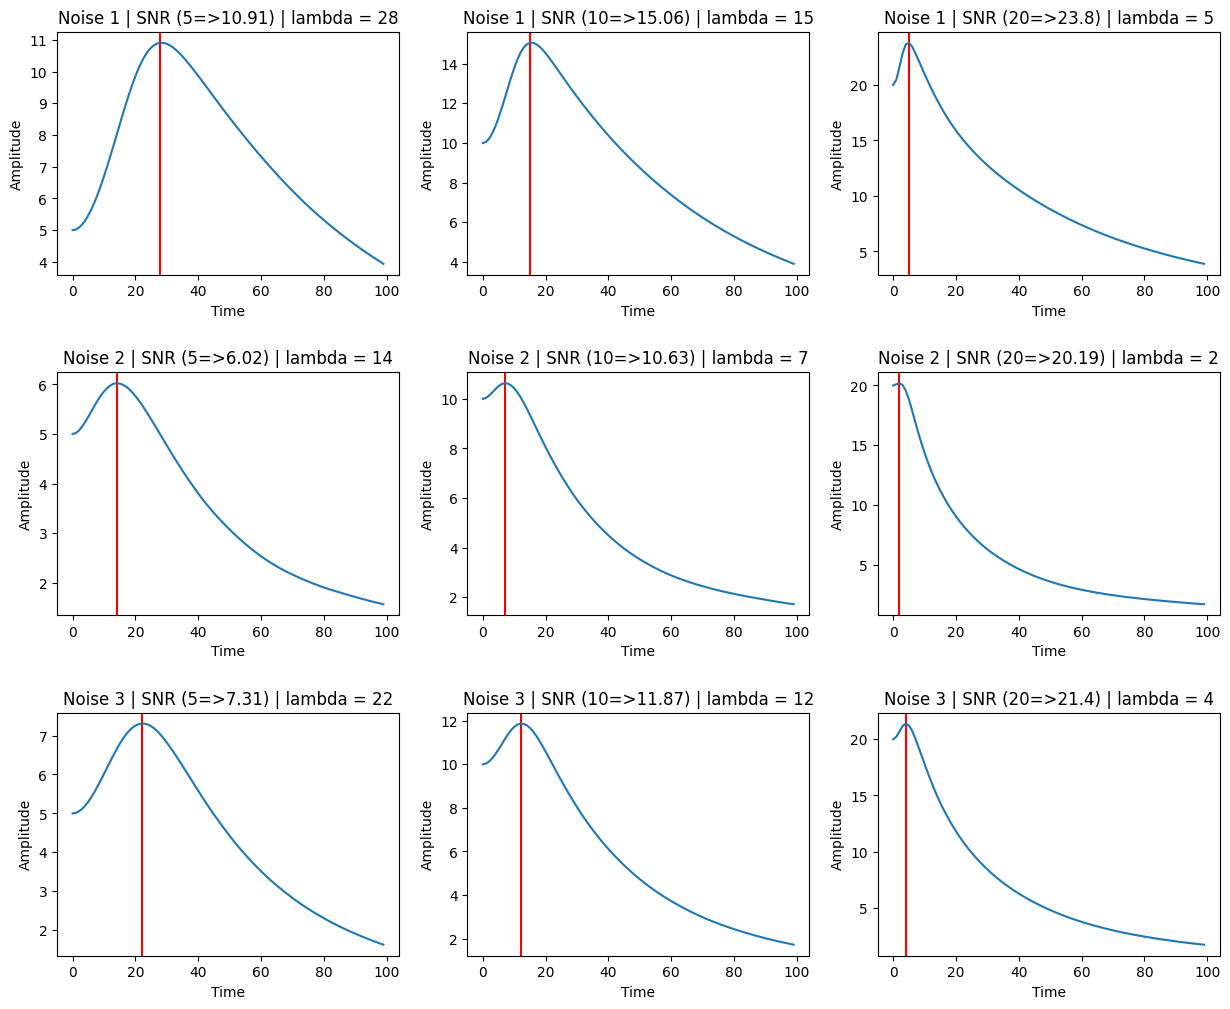

In [ ]:
# plot the noisy music side by side
fig, axs = plt.subplots(len(noise_files), len(SNR_LIST), figsize=(15,12))
for i, noise in enumerate(noise_files):
    for j,snr in enumerate(SNR_LIST):
        snr_list = get_snr_curve(noisy_music_dict[noise][snr], noises_dict[noise], music_sig)
        #find the best lambda where the SNR is maximum
        best_lmbd = np.argmax(snr_list)
        # denoise the music
        denoised_music = spectral_substraction_denoising(noisy_music_dict[noise][snr], noises_dict[noise], rate, best_lmbd)
        # plot red line at the best lambda
        axs[i][j].axvline(x=best_lmbd, color='r', linestyle='-')
        axs[i][j].plot(lmbd_list, snr_list, label=noise)
        axs[i][j].set_title(f"Noise {i+1} | SNR ({snr}=>{snr_list[best_lmbd].round(2)}) | lambda = {best_lmbd}")
        axs[i][j].set_xlabel("Time")
        axs[i][j].set_ylabel("Amplitude")

plt.subplots_adjust(hspace = 0.4)
plt.show()

As expected, we see that when denoising sound with lower SNR, we need to use higher values of lambda.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=961b9ed5-2447-492c-8401-f8553fdda975' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>